Algoritmos Genéticos y Optimización Heurística - UTN-FRT
# **Trabajo Práctico N°6** 
##**Tema**: Algoritmos Genéticos Niching##

Aplique el Algoritmo Genetico Niching visto en clases (Deterministic Crowding) a las funciones De Jong 2, 5 y 6. En cada caso se pide:
- Ajuste los parametros de forma de asegurar convergencia (o sea, de forma de poder asegurar que con esos parametros, el AG converge a una solucion aceptable 8 de cada 10 como mnimo).
- Aplique el algoritmo Genético Simple a los mismos problemas, utilizando los mismos operadores.
- Analice el comportamiento del algoritmo y las soluciones obtenidas, comparelo con el Algoritmo Genético Simple.


In [ ]:
import random, math

def DeterministicCrowding(Pop, cant_generac, Bounds, Enteras, xover, f, dist, callback=None):
    """
    Algoritmo Niching - Deterministic Crowding
    Parametros:
    - Pop: list. poblacion inicial (lista de listas).
    - cant_generac: int. Cantidad de iteraciones del algoritmo.
    - Bounds: list: Matriz que indica los valores max y min de cada variable.
    - Enteras: list. Vector booleano que indica si las coordenadas son enteras.
    - xov: function. Operador de cruzamiento.
    - f: function. Funcion de evaluacion. Debe recibir como parametro un vector
      solucion y devolver un numero real.
    - callback: function. Funcion que se ejecuta una vez en cada iteracion (para  
      mostrar resultados parciales). Usar None para deshabilitarla.
    Salida
    - soluc: list. Vector solucion que obtuvo fitness mas alto.
    - solF: float. Valor de evaluacion de la mejor solucion.
    - Pop: list. Poblacion final.
    - Fit: list. Fitness de cada individuo de la poblacion final.
    - traceBest: list. Vector con los mejores valores de fitness obtenidos en
      cada generacion. Se puede utilizar para determinar si el algoritmo 
      llego a crowding.
    - traceAvg: list. Vector con los valores promedio de fitness
      obtenidos en cada generacion.
    """
    #inicializacion
    sol = []
    solF = None
    cant_soluc = len(Pop)
    Fit = [None] * cant_soluc
    traceBest = []
    traceAvg = []
    bestSols = []
    
    #verifico los parametros de entrada
    if cant_soluc < 2:
        print('La Poblacion debe tener al menos dos individuos.')
        return sol, solF, Pop, Fit, traceBest, traceAvg, bestSols
    cant_variables = len(Pop[0])   
    if len(Bounds) != cant_variables or len(Bounds[0]) != 2:
        print('El tamano de la matriz Bounds es incorrecto.')
        return sol, solF, Pop, Fit, traceBest, traceAvg, bestSols
    if len(Enteras) != cant_variables:
        print('El tamano del vector Enteras es incorrecto.')
        return sol, solF, Pop, Fit, traceBest, traceAvg, bestSols

    #inicializo variables para reducir tiempo de calculo
    cb_param = None
    p = [i for i in range(cant_soluc)]
    
    #realizo las evaluaciones de la poblacion inicial.
    for k in range(cant_soluc):
        Pop[k] = [xi if not Enteras[i] else int(xi+0.5) for i, xi in enumerate(Pop[k])]
        Fit[k] = f(Pop[k])
    if callback != None:
        cb_param = callback(Pop, Fit, Bounds, 0, cant_generac, cb_param)
        
    for gen in range(cant_generac):
        #posicion al azar
        p = [i for i in range(cant_soluc)]
        random.shuffle(p)
        for k in range(0, cant_soluc-1, 2):
            #agrupo por pares
            p1, p2 = (Pop[p[k]], Pop[p[k+1]])
            Fp1, Fp2 = (Fit[p[k]], Fit[p[k+1]])
            #cruzamiento    
            c1, c2 = xover(p1, p2)
            #realizo las evaluaciones
            c1 = [xi if not Enteras[i] else int(xi+0.5) for i, xi in enumerate(c1)]
            Fc1 = f(c1)
            c2 = [xi if not Enteras[i] else int(xi+0.5) for i, xi in enumerate(c2)]
            Fc2 = f(c2)
            #crowding
            if dist(p1,c1) + dist(p2,c2) <= dist(p1,c2) + dist(p2,c1):
                if Fc1 > Fp1:
                    Pop[p[k]] = c1
                    Fit[p[k]] = Fc1
                if Fc2 > Fp2:
                    Pop[p[k+1]] = c2
                    Fit[p[k+1]] = Fc2
            else:
                if Fc2 > Fp1:
                    Pop[p[k]] = c2
                    Fit[p[k]] = Fc2
                if Fc1 > Fp2:
                    Pop[p[k+1]] = c1
                    Fit[p[k+1]] = Fc1
        
        #obtengo el orden de los individuos
        p_orden = sorted(range(len(Fit)), key=lambda k: Fit[k], reverse=True)

        #datos estadisticos
        traceBest.append(Fit[p_orden[0]])
        traceAvg.append(sum(Fit) / len(Fit))
        bestSols.append([xi for xi in Pop[p_orden[0]]])

        #funcion para graficar, mostrar, etc.
        if callback != None:
            cb_param = callback(Pop, Fit, Bounds, gen, cant_generac, cb_param)
        
    #busco la mejor solucion obtenida
    solF = Fit[p_orden[0]]
    sol = Pop[p_orden[0]]
    
    return sol, solF, Pop, Fit, traceBest, traceAvg, bestSols

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output
from time import sleep

def graficarEvolucionFitness(best, mean):
    """Método para graficar la evolucion del fitness con las iteraciones.
    Parametros
    best, mean : list. Lista con los valores de evaluación de la mejor y peor solución.
    """
    fig = plt.figure()
    ax = plt.axes()
    x = range(len(best));
    plt.plot(x, best, label='Mejor solución');
    plt.plot(x, mean, label='Promedio poblacion');
    plt.title('Valores de Evaluación')
    plt.xlabel('Iteración')
    plt.ylabel('Fitness')
    plt.grid()
    plt.legend()

def graficarCaminata(fitness, solutions,  bounds, resolution, alpha=0.5):
    """Graficar la funcion de evaluacion y las soluciones encontradas.
    Parametros
    fitness : function. Función de evaluación a optimizar
    solutions : list. Lista de soluciones encontradas.
    bounds: list(tuple). Matriz de tamano nx2, donde n es la cantidad de 
    variables del problema (cantidad de coordenadas del vector solución). 
    resolution : float. Resolución para graficar la función (mayor a 0.1).
    alpha : float. Transparencia para el grafico de la función.
    """
    ranges = []
    for i in range(len(bounds)):
        steps = round((bounds[i][1] - bounds[i][0]) / resolution)
        ranges.append([bounds[i][0] + s*resolution for s in range(steps)])
    if len(bounds) == 1:
        fig = plt.figure()
        ax = fig.gca()
        X = [xi for xi in ranges[0]]
        Y = [fitness(xi) for xi in ranges[0]]
        plt.plot(X, Y, antialiased=False, alpha=alpha)
        plt.title('Función de Evaluación')
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.grid()
        x = [s[0] for s in solutions]
        y = [fitness(s) for s in solutions]
        ax.scatter(x, y, c='k', marker='o')
    elif len(bounds) == 2:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        X = []; Y = []; Z = []
        for i, xi in enumerate(ranges[0]):
            X.append([xi for yj in ranges[1]])
            Y.append([yj for yj in ranges[1]])
            Z.append([fitness([xi, yj]) for yj in ranges[1]])
        surf = ax.plot_surface(X, Y, np.array(Z), cmap=cm.coolwarm, linewidth=0, 
            antialiased=False, alpha=alpha)
        plt.title('Función de Evaluación')
        plt.xlabel('x')
        plt.ylabel('y')
        ax.set_zlabel('f(x,y)')
        fig.colorbar(surf, shrink=0.5, aspect=5)
        x = [s[0] for s in solutions]
        y = [s[1] for s in solutions]
        z = [fitness(s) for s in solutions]
        ax.scatter(x, y, z, c='k', marker='o')
    else: 
        return False
    return True

def callback_graficar(Pop, Fit, Bounds, gen, cant_generac, params):
    v = max(Fit)
    if gen == 0 and len(Bounds) == 2:
        params = v
        plt.figure()
    if v >= params and len(Bounds) == 2:
        fig = plt.gcf()
        ax = fig.gca()
        ax.clear()
        x = [s[0] for s in Pop]
        y = [s[1] for s in Pop]
        ax.scatter(x, y, c='k', marker='o')
        ax.set_xlim(Bounds[0])
        ax.set_ylim(Bounds[1])
        plt.title("Generacion: {0} - Fitness: {1}".format(gen, v))
        plt.xlabel('x')
        plt.ylabel('y')
        plt.grid()
        clear_output(wait=True)     
        plt.show()
        sleep(0.05)
    return params

def heuclidea(P1,P2):
  return math.sqrt(sum([(P1[i]-P2[i])**2 for i in range(len(P1))]))
  

## Generar población inicial

In [ ]:
def init_pop(cant_individuos, Bounds):
    return [[random.uniform(B[0],B[1]) for B in Bounds] for i in range(cant_individuos)]

## Operador de cruzamiento

In [ ]:
def xov_uniform(P1, P2):
    """Operador Uniform Crossover para Algoritmos Geneticos.
    Parametros:
    P1: list. Lista correspondiente a uno de los individuos padres a cruzar.
    P2: list. Lista correspondiente a uno de los individuos padres a cruzar.
    """
    mascara = [random.randint(0,1) for i in range(len(P1))]
 
    C1 = [P1[i] if m==0 else P2[i] for i,m in enumerate(mascara)]
 
    C2 = [P2[i] if m==0 else P1[i] for i,m in enumerate(mascara)]
 
    return C1, C2

## Problema 1: Función De Jong 2.


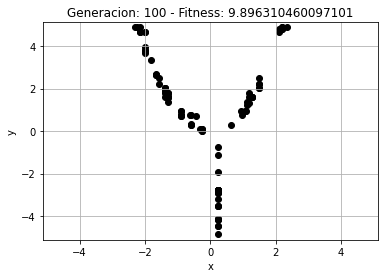

DeJong2


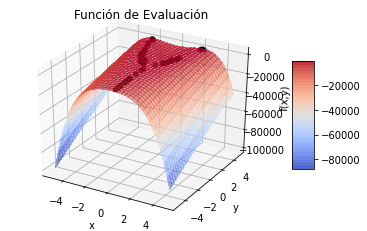

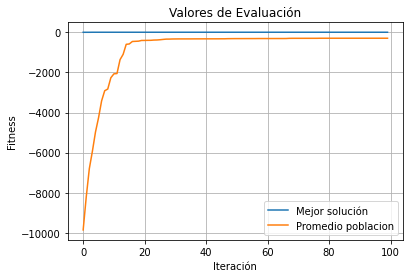

In [ ]:
def DeJong2(sol):
  return -100 * (sol[0]**2 - sol[1])**2 + (1-sol[0])**2

Bounds = [[-5.12,5.12],[-5.12,5.12]]
Enteras = [False]*len(Bounds)
fitness = DeJong2
distancia = heuclidea
callback = callback_graficar

cant_individuos = 100
cant_generac = 100
xover = xov_uniform

Pop = []
Pop = init_pop(cant_individuos, Bounds)
sol, solF, Pop, Fit, traceBest, traceAvg, bestSols = DeterministicCrowding(
    Pop, cant_generac, Bounds, Enteras, xover, fitness, distancia, callback)

callback_graficar(Pop, Fit, Bounds, cant_generac, cant_generac, -math.inf)
graficarCaminata(fitness, Pop,  Bounds, 0.1, alpha=0.5)
graficarEvolucionFitness(traceBest, traceAvg)

print('DeJong2')

## Problema 2: Función De Jong 5.


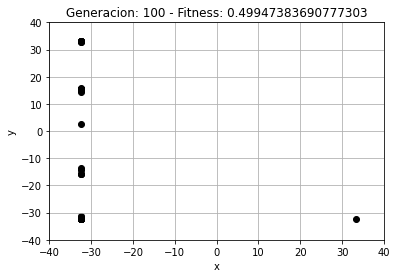

DeJong5


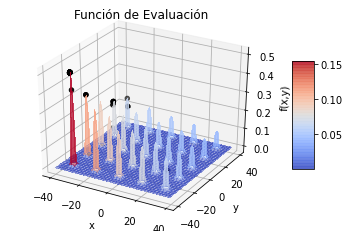

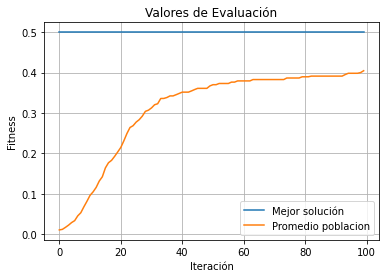

In [ ]:
def DeJong5(sol):
  A0 = [-32,-16,0,16,32]
  return sum([1 / (i+1 + (sol[0]-A0[j])**6 + (j+1) + (sol[1]-A0[i])**6) for i in range(5) for j in range(5)])

Bounds = [[-40,40],[-40,40]]
Enteras = [False]*len(Bounds)
fitness = DeJong5
distancia = heuclidea
callback = callback_graficar

cant_individuos = 100
cant_generac = 100
xover = xov_uniform

Pop = []
Pop = init_pop(cant_individuos, Bounds)
sol, solF, Pop, Fit, traceBest, traceAvg, bestSols = DeterministicCrowding(
   Pop, cant_generac, Bounds, Enteras, xover, fitness, distancia, callback)

callback_graficar(Pop, Fit, Bounds, cant_generac, cant_generac, -math.inf)
graficarCaminata(fitness, Pop,  Bounds, 1.0, alpha=0.5)
graficarEvolucionFitness(traceBest, traceAvg)

print('DeJong5')

## Problema 3: Función De Jong 6.


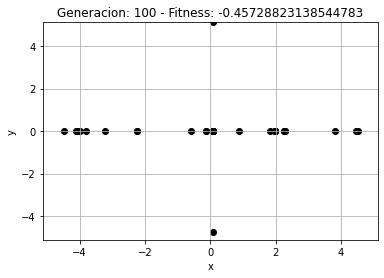

DeJong 6 - Rastriguin


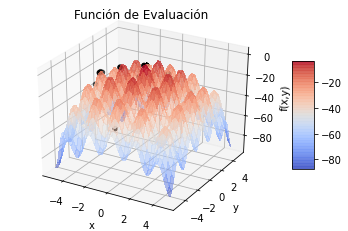

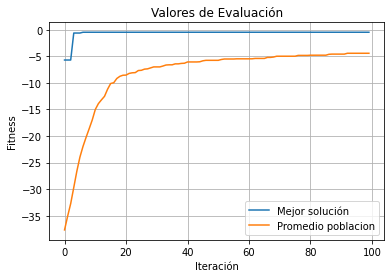

In [ ]:
def DeJong6(sol):
  return -20 - sum([xi**2 for xi in sol]) + 10*sum([math.cos(math.pi*xi) for xi in sol])

Bounds = [[-5.12,5.12],[-5.12,5.12]]
Enteras = [False]*len(Bounds)
fitness = DeJong6
distancia = heuclidea
callback = callback_graficar

cant_individuos = 100
cant_generac = 100
xover = xov_uniform

Pop = []
Pop = init_pop(cant_individuos, Bounds)
sol, solF, Pop, Fit, traceBest, traceAvg, bestSols = DeterministicCrowding(
    Pop, cant_generac, Bounds, Enteras, xover, fitness, distancia, callback)

callback_graficar(Pop, Fit, Bounds, cant_generac, cant_generac, -math.inf)
graficarCaminata(fitness, Pop,  Bounds, 0.1, alpha=0.5)
graficarEvolucionFitness(traceBest, traceAvg)

print('DeJong 6 - Rastriguin')